<a href="https://colab.research.google.com/github/omerhac/flower_calssification/blob/master/flower_classificaiton_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt
import math, os, sys, re
import numpy as np
import tensorflow as tf
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
print("tf version: " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

tf version: 2.2.0-rc2


# Hardware detection


In [2]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)


INFO:tensorflow:Initializing the TPU system: grpc://10.100.98.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.98.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  grpc://10.100.98.218:8470
Number of accelerators:  8


## Utilities

In [0]:
def get_numpy_batch(dataset, n_samples):
  """get numpy array of n samples"""
  dataset = dataset.shuffle(buffer_size=10)
  batched = dataset.batch(n_samples)
  for images, labels in batched:
    return images.numpy(), labels.numpy()

def show_n_samples(dataset, n):
  """prints n images and labels"""
  plt.figure(figsize = (2 * n, 2 *n))

  rows = math.ceil(n / 3)

  batch_images, batch_labels = get_numpy_batch(dataset, n)

  for i, image in enumerate(batch_images):
    plt.subplot(rows, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[batch_labels[i]])
  
  plt.show()

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def count_dataset_items(dataset):
  # counts items iterativly in the data set. requaiers some time...
  count = 0
  for obj in dataset:
    count += 1
  
  return count

def display_training_curves(hist, metric='accuracy', with_val=False):
  """display learning curves for keras history dict, args: history dict, with val --> boolean with/without val"""
  plt.figure(figsize=(18,6))

  # accuracy plots
  plt.subplot(1,2,1)
  plt.plot(hist[metric])
  
  if with_val:
    plt.plot(hist['val_' + metric])
    plt.legend(['Train', 'Validation'])
  
  else:
    plt.legend(['Train'])
  
  plt.title('Model accuracy')
  plt.xlabel('EPOCH')
  plt.ylabel('Accuracy')

  # loss plots
  plt.subplot(1,2,2)
  plt.plot(hist['loss'])

  if with_val:
    plt.plot(hist['val_loss'])
    plt.legend(['Train loss', 'Val loss'])
  
  else:
    plt.legend(['Train loss'])
  
  plt.title('Model loss')
  plt.xlabel('EPOCH')
  plt.ylabel('Loss')
  plt.show()

def display_training_curves_without_dict(accuracy, val_accuracy, loss, val_loss):
  """display learning curves. args: accuracy iterable, val iterable , loss iterable, val_los iterable"""
  keras_dict = {'accuracy': accuracy, 'val_accuracy': val_accuracy, 'loss': loss, 'val_loss': val_loss}
  return display_training_curves(keras_dict)

  
def display_model_predictions(model, dataset):
  """Displays 9 images and their predictions"""

  batch_images, batch_labels = get_numpy_batch(dataset, 9)
  predictions = model.predict(batch_images) # predict images labels
  
  plt.figure(figsize=(18,18))

  for i, image in enumerate(batch_images):
    # def plot
    plt.subplot(3,3,i + 1)
    plt.imshow(image)

    # write prediction as titles
    pred =np.argmax(predictions[i])
    if pred == batch_labels[i]:
      plt.title(CLASSES[pred], fontdict={'color':'g'})

    else:
      plt.title(CLASSES[pred] + " WRONG --> " + CLASSES[batch_labels[i]], fontdict={'color': 'r'})
    
  plt.show()



# Loading images

In [0]:
# read tfrecords from gcs
def read_tfrecord(example):
  """Parses one tf record to image, class, one_hot_class"""
  features = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "class": tf.io.FixedLenFeature([], tf.int64),
  }

  example = tf.io.parse_example(example, features)
  image = tf.image.decode_jpeg(example['image'], channels=3)
  image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
  image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
  label = tf.cast(example['class'], tf.int32)
  return image, label

def load_tfrecord_dataset(dataset_filenames):
  """Loads a TFRecord dataset. args: dataset_filnames --> list of strings of files paths"""

  # allows for no order parallel reading
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(dataset_filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_dataset(training_filenames):
  """ Read dataset from tfrecords, shuffle and prefetch it"""

  dataset = load_tfrecord_dataset(training_filenames)
  dataset = dataset.shuffle(2048)
  dataset = dataset.prefetch(AUTO)

  return dataset


In [5]:
# getting image paths
IMAGE_SIZE = [331, 331]

GCS_PATH = "gs://kds-b2e6cdbc4af76dcf0363776c09c12fe46872cab211d1de9f60ec7aec" # GCS path for competition data

# dict for paths to different image sizes
GCS_PATH_SELECT = { # available image sizes
    192: GCS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_PATH + '/tfrecords-jpeg-512x512'
}

# get full path with image size and split to train / val / test
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
TRAINING_FILENAMES = TRAINING_FILENAMES + TRAINING_FILENAMES # repeat dataset
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

# get length of datasets
TRAINING_LENGTH = count_data_items(TRAINING_FILENAMES)
VALIDATION_LENGTH = count_data_items(VALIDATION_FILENAMES)
TEST_LENGTH = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(TRAINING_LENGTH,VALIDATION_LENGTH, TEST_LENGTH))

Dataset: 25506 training images, 3712 validation images, 7382 unlabeled test images


In [6]:
whole_dataset = get_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES)
training_dataset = get_dataset(TRAINING_FILENAMES)
validation_dataset = load_tfrecord_dataset(VALIDATION_FILENAMES)
test_dataset = load_tfrecord_dataset(TEST_FILENAMES) # have to create a function to load test items from tfrecord

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = (TRAINING_LENGTH+ VALIDATION_LENGTH) // BATCH_SIZE
batched_whole_dataset = whole_dataset.batch(BATCH_SIZE)
batched_training_dataset = training_dataset.batch(BATCH_SIZE)
batched_validation_dataset = validation_dataset.batch(BATCH_SIZE)

### testing paragraph
batched_whole_dataset = whole_dataset.batch(BATCH_SIZE)
print("Steps per epoch: {}".format(STEPS_PER_EPOCH))

Steps per epoch: 228


## Flower classes


In [0]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Data augmentation

In [0]:
def random_scale_and_shift(image, resize_lower_threshold=0.5):
  """ A function that with probability 0.5 takes an image, resize (randomly between resize_lower_threshold and 1) and shifts it by random values."""

  if np.random.rand() > 0.5:
    return image

  height, width, _ = image.shape
  resize_ratio = np.random.uniform(low=resize_lower_threshold, high=1) # set resize ratio

  # get new dimensions
  new_height = int(resize_ratio * height)
  new_width = int(resize_ratio * width)  

  # resize image
  resized_image = tf.image.resize(image, size=tf.constant([new_height, new_width], dtype='int32'))

  # shit image
  new_image = np.random.uniform(size=image.shape) # create ranodm noise image
  row_start = np.random.randint(0, high=height-new_height)
  column_start = np.random.randint(0, high=width-new_width)
  new_image[row_start:row_start+new_height, column_start:column_start+new_width,:] = resized_image

  return new_image

def augment_image(image, label):
  
  """Randomly flip and saturate an image. args: image, label"""
  aug_image = tf.image.random_flip_left_right(image)
  #aug_image = random_scale_and_shift(image)

  return aug_image, label


def augment_tf_dataset(dataset):
  double_data = dataset
  
  return double_data.map(augment_image, num_parallel_calls=AUTO)
  
aug_batched_training_dataset = augment_tf_dataset(training_dataset).batch(BATCH_SIZE)

# Simple transfer learning model

*   untrainable weights



In [0]:
def get_pretrained_model(trainable=False):
  # get xception / densenet pretrained model
  #pretrained = keras.applications.Xception(include_top=False, input_shape=[*IMAGE_SIZE,3])
  pretrained = tf.keras.applications.DenseNet201(include_top=False, input_shape=[*IMAGE_SIZE,3], weights='imagenet')
  pretrained.trainable = trainable

  # define model
  model = tf.keras.models.Sequential([
    pretrained,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(CLASSES), activation='softmax')
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  return model

In [10]:
with strategy.scope():
  model = get_pretrained_model()
  model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 10, 10, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 199,784
Non-trainable params: 18,321,984
_________________________________________________________________


In [11]:
hist = model.fit(batched_training_dataset, epochs=10, validation_data=batched_validation_dataset)

Epoch 1/10
200/200 [==============================] - 61s 303ms/step - loss: 2.2350 - sparse_categorical_accuracy: 0.5336 - val_loss: 1.3290 - val_sparse_categorical_accuracy: 0.7309
Epoch 2/10
200/200 [==============================] - 41s 207ms/step - loss: 0.9492 - sparse_categorical_accuracy: 0.8162 - val_loss: 0.8957 - val_sparse_categorical_accuracy: 0.8103
Epoch 3/10
200/200 [==============================] - 41s 207ms/step - loss: 0.6441 - sparse_categorical_accuracy: 0.8731 - val_loss: 0.7412 - val_sparse_categorical_accuracy: 0.8413
Epoch 4/10
200/200 [==============================] - 41s 207ms/step - loss: 0.4967 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.6638 - val_sparse_categorical_accuracy: 0.8483
Epoch 5/10
200/200 [==============================] - 42s 209ms/step - loss: 0.4058 - sparse_categorical_accuracy: 0.9221 - val_loss: 0.6132 - val_sparse_categorical_accuracy: 0.8594
Epoch 6/10
200/200 [==============================] - 41s 205ms/step - loss: 0.3409 -

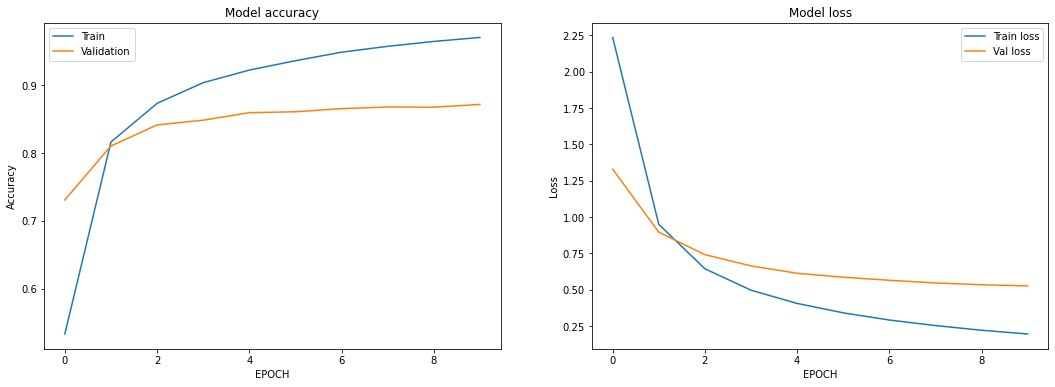

In [12]:
display_training_curves(hist.history, metric='sparse_categorical_accuracy', with_val=True)

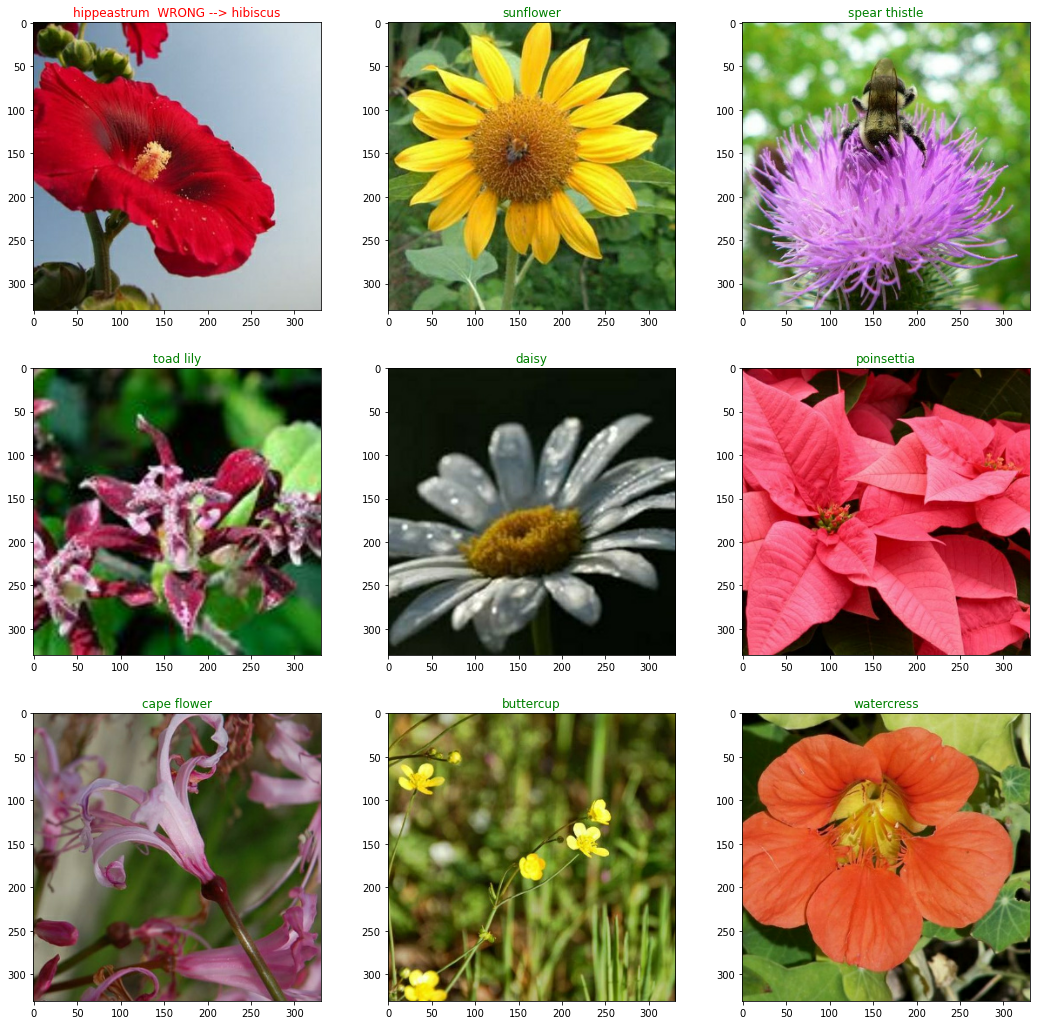

In [13]:
display_model_predictions(model, validation_dataset)

# Compute unbalanced class weights

In [0]:
from sklearn.utils import class_weight
y_train = training_dataset.map(lambda image, label: label).as_numpy_iterator()
y_train = [x for x in y_train]
class_weights = class_weight.compute_class_weight('balanced', [x for x in range(len(CLASSES))], y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))} # converting to dict

# Transfer learning with trainable weights

In [25]:
with strategy.scope():
  model = get_pretrained_model(trainable=True)
  model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 10, 10, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


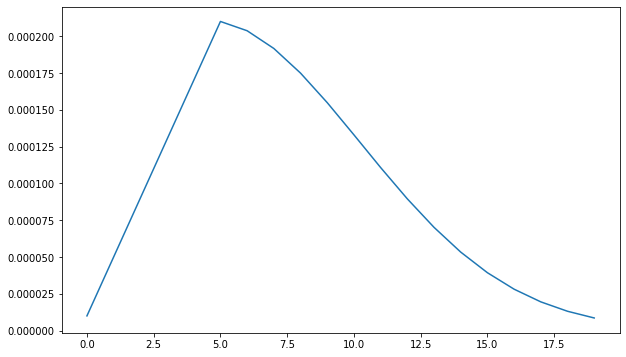

In [16]:
def step_lr_schedule(epoch, current, decay_rate=0.8, initial_lr=1e-5, linear_slope= 1e-5, peak_slope=5):
  """transfer learning step scheduler. args: epoch number, curren learning rate"""

  if epoch <= peak_slope:
    return initial_lr + linear_slope * epoch
  else:
    return current * decay_rate**(epoch-peak_slope)

def get_transfer_learning_schedule(decay_rate=0.8, initial_lr=1e-5, linear_slope=1e-5, peak_slope=5):
  """Get a learning rate step scheduler. args: parameters for the step curve"""

  return lambda epoch, current: step_lr_schedule(epoch, current, decay_rate, initial_lr, linear_slope, peak_slope)

def plot_lr_schedule(lr_schedule, num_epochs):
  """ given a learning schedule function, prints its graph"""

  current = 0 # initial learning rate
  lrs = []
  epochs = range(num_epochs)
  for epoch in epochs:
    lr = lr_schedule(epoch, current)
    current = lr # change current learning rate to function outcome
    lrs.append(lr)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, lrs)

transfer_lr_schedule = get_transfer_learning_schedule(decay_rate=0.97, initial_lr=1e-5, linear_slope=4e-5, peak_slope=5)

# visualize lr
plot_lr_schedule(transfer_lr_schedule, 20)

In [23]:
## creating callbacks
schedule = tf.keras.callbacks.LearningRateScheduler(transfer_lr_schedule, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='auto', restore_best_weights=True)
model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath='chkpt', monitor='sparse_categorical_crossentropy', verbose=1,save_best_only=True, period=5)

In [0]:
# train_model
hist = model.fit(aug_batched_training_dataset, epochs = 25,
                 callbacks=[schedule], validation_data=batched_validation_dataset, class_weight=class_weights)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25


# Custom cnn

In [0]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D, concatenate, Input
from tensorflow.keras import  Model

def inception_block(x, num_3_filters, num_1_filters, batch_norm_moment = 0.9):
  side_pool = MaxPooling2D(pool_size=(2,2))(x)

  # middle branch
  middle_branch_1 = Conv2D(num_1_filters, kernel_size=(1,1), strides=(1,1), activation = 'relu', padding='same')(x)
  middle_branch_1 = BatchNormalization(momentum=batch_norm_moment)(middle_branch_1)
  middle_branch_3 = Conv2D(num_3_filters, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same')(middle_branch_1)
  middle_branch_3 = BatchNormalization(momentum=batch_norm_moment)(middle_branch_3)

  # big branch
  big_branch_1 = Conv2D(num_1_filters, kernel_size=(1,1), strides=(1,1), activation = 'relu', padding='same')(x)
  big_branch_1 = BatchNormalization(momentum=batch_norm_moment)(big_branch_1)
  big_branch_3_1 = Conv2D(num_3_filters, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(big_branch_1)
  big_branch_3_1 = BatchNormalization(momentum=batch_norm_moment)(big_branch_3_1)
  big_branch_3_2 = Conv2D(num_3_filters, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same')(big_branch_3_1)
  big_branch_3_2 = BatchNormalization(momentum=batch_norm_moment)(big_branch_3_2)

  depth_concat = concatenate([side_pool, middle_branch_3, big_branch_3_2])
  
  return depth_concat

def inception(num_3_filters, num_1_filters, batch_norm_moment = 0.9):
  return lambda x: inception_block(x, num_3_filters, num_1_filters, batch_norm_moment = 0.9)

x = Input(shape=[*IMAGE_SIZE, 3])
c1 = Conv2D(6, kernel_size=(3,3), padding='same', activation='relu')(x)
i1 = inception(24,12)(c1)
g = GlobalAveragePooling2D()(i1)
d = Dense(len(CLASSES), activation='softmax')(g)
model = Model(inputs=x, outputs=d)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Apply object detection

In [0]:
!git clone https://github.com/endernewton/tf-faster-rcnn.git

# Key takeaways:
* always use tf.keras and not keras!
* for a transfer learning model, its really importent to set whether the model is trainable by "pretrained_model.trainable = True/False" and not by "model.layer.trainable = True/False". not sure why..
* for a transfer learning model training you should do one of the two:
  - warmap top layers for some epochs
  - use a step curve learning rate
  - dont use both!
* pay attention to the metric.. sparse_caterogical_accuracy is very different from accuracy. also the los..
* class weighting didnt prove to be of much help
* strong augmentation (random_scale_and_shift) could be a problem in transfer learning
* image size between 512x512 and 331x331 didnt have any differance
* keras callbacks are good and easy to use
* there isnt much difference in accuracy on top notch transfer learning models